# Fitting COVID19 trends using Bayesian method

In this assignment, our goal is to fit the COVID 19 trends (confirmed cases of COVID 19 as a function of date) using the generalized growth model given by

\begin{align}
\frac{d C(t)}{dt} = r C(t)^p, \label{eq:ode} \tag{1}
\end{align}

where $t \in [0,T]$ is the time (in units of days), $r \geq 0$ is the growth rate, $p
\in [0,1]$ is the 'decceleration of growth' parameter, see **Viboud et al 2015**. Special cases: $p = 0$ gives linear growth model and $p=1$ gives exponential growth model. 

$C : [0,T] \to [0, \infty)$ is the total confirmed COVID 19 cases at time $t$. When $0 < p < 1$, Eq (1) can be solved to get 

\begin{align}
C(t) = \left( \frac{r}{m}t + (C_0)^{1/m} \right)^m, \label{eq:model} \tag{2}
\end{align}

where $m = 1/(1 - p)$ and $C_0 = C(0)$ is the initial condition. For special cases $p=0$ and $p=1$, $C$ can be found easily.

# Problem

We cosider COVID 19 data at discrete times $\bar{t} = (t_1=0, t_2=1, ..., t_N=83)$, where $N = 84$, and corresponding total confirmed cases $Y(\bar{t}) = (Y_1, Y_2, ..., Y_N)$.

Model prediction is $C(\bar{t}) = (C(t_1), C(t_2), ..., C(t_N))$ where $C(t_i)$ is given by Eq (2). The model parameters are $\theta = (r, p)$. Take uniform prior for $\theta$ and consider a Guassian noise with zero mean and standard deviation $\sigma$. Divide the data in calibration and validation by taking first $N_c = 50$ as the calibration data and rest $N_v = N - N_c$ as validation data. You can also try different priors for parameters and divide data differently in calibration and validation set.

Problem: Predict the total confirmed cases at $T = 100$ day for three countries US, Japan, and South Korea.

## Data
Data for current epidemic COVID 19 can be found in several places such as:

- [datasets/covid-19](https://github.com/datasets/covid-19)

- [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

- [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)


In [StudyCovid19](https://github.com/prashjha/StudyCovid19) you will find python scripts to process data and this notebook in directory `process/bayesian`.


Below we plot the confirmed cases for various countries

Num days: 84


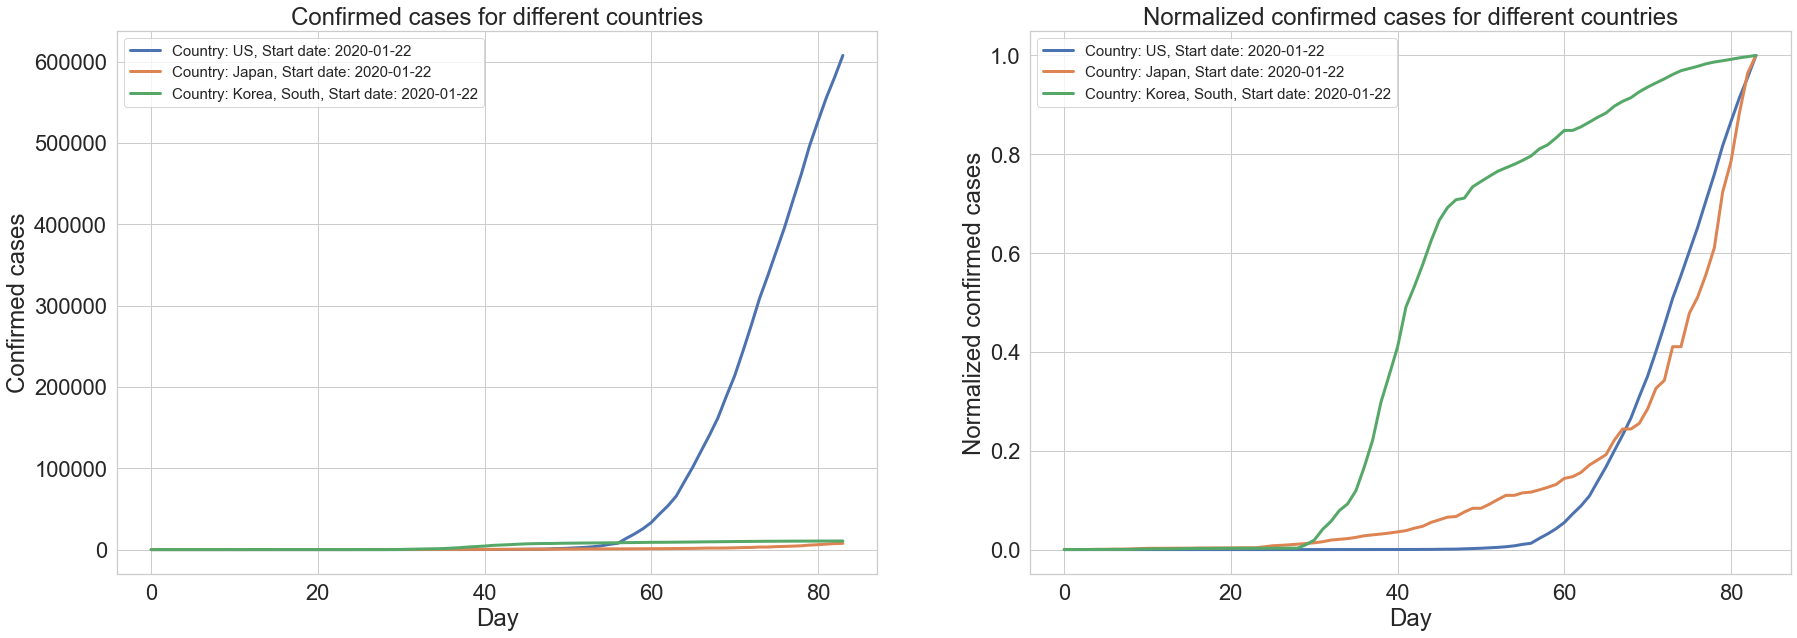

In [1]:
import sys
sys.path.insert(0,'../')

import pandas as pd
import numpy as np
import scipy
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from data import plot_countries_all_plus_normalize_1 as plot
from data import save_country_data_1 as save

# import models
from models import model1, model2, model3

df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')
# plot
plot(df, ['US', 'Japan', 'Korea, South'])
# save data
save(df, ['US', 'Japan', 'Korea, South'])

In [2]:
df_US = pd.read_csv('./US.csv', header=None)
df_Korea = pd.read_csv('./Korea, South.csv', header=None)
df_Japan = pd.read_csv('./Japan.csv', header=None)

In [3]:
calibration_US, validation_US = df_US.iloc[:51], df_US.iloc[51:]
calibration_Korea, validation_Korea = df_Korea.iloc[:51], df_Korea.iloc[51:]
calibration_Japan, validation_Japan = df_Japan.iloc[:51], df_Japan.iloc[51:]

calibration_times = calibration_US[0].to_numpy()
validation_times = validation_US[0].to_numpy()

## Model 1 US

In [123]:
calibration_cases = calibration_US[1].to_numpy()

In [124]:
# Following: https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

transition_model1 = lambda theta: [np.random.normal(theta[1], 20), np.random.normal(theta[1], 0.1)]

def prior(theta):
    if (theta[0] <= 0 or theta[1] <= 0):
        return 1.e-8
    elif theta[1] >= 0.99:
        return 1.e-8
    else:
        return 1

def log_lik(theta, data):
    return np.log(np.sum(scipy.stats.expon(scale=theta[0], loc=theta[1]).pdf(data)))

def acceptance(theta, theta_new):
    if theta_new > theta:
        return True
    else:
        accept = np.random.uniform(0, 1)
        return (accept < (np.exp(theta_new - theta)))

def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)  
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data) 
        if (acceptance_rule(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [125]:
accepted, rejected = metropolis_hastings(log_lik, prior, transition_model1, [100, 0.2], 50000, calibration_cases, acceptance)
after_burn_in = int(len(accepted) * 0.5)
print(after_burn_in)
accepted = accepted.T

9660


In [126]:
r = accepted[0, after_burn_in:]
p = accepted[1, after_burn_in:]
print(len(r))
r_average = np.average(r)
r_std = np.std(r)
p_average = np.average(p)
p_std = np.std(p)

9660


R average:  14.098815333114764
P average:  0.4988961980656621


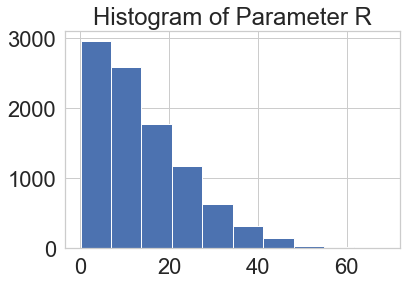

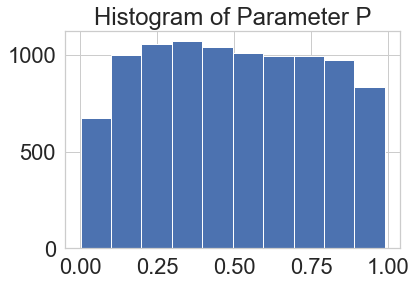

In [127]:
plt.hist(r)
plt.title('Histogram of Parameter R')
plt.figure()
plt.hist(p)
plt.title('Histogram of Parameter P')

print('R average: ', r_average)
print('P average: ', p_average)

In [128]:
t = [float(i) for i in range(84)]
T = 100.
C_0 = 1.

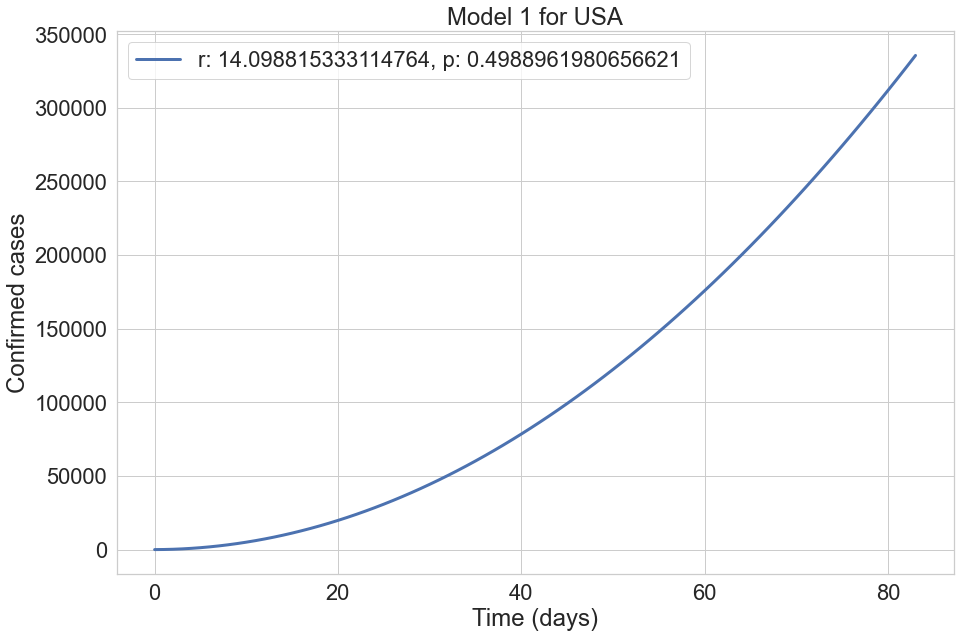

In [129]:
C = model1([r_average, p_average], t, [C_0, T])
fig = plt.figure(figsize=(15., 10.))
plt.plot(t, C, label='r: {}, p: {}'.format(r_average, p_average))
plt.title('Model 1 for USA')
plt.xlabel('Time (days)')
plt.ylabel('Confirmed cases')
plt.legend()

In [130]:
model1([r_average, p_average], [T], [C_0])

array([486289.38565645])

In [131]:
validation_cases = validation_US[1].to_numpy()

In [132]:
transition_model1 = lambda theta: [np.random.normal(theta[1], r_std), np.random.normal(theta[1], p_std)]
print(r_std)
print(p_std)
print(r_average)
print(p_average)

10.773301539961057
0.2718328313433086
14.098815333114764
0.4988961980656621


In [133]:
val_accepted, val_rejected = metropolis_hastings(log_lik, prior, transition_model1, [r_average, p_average], 50000, validation_cases, acceptance)
print(len(val_accepted))
after_burn_in = int(len(val_accepted) * 0.5)
val_accepted = val_accepted.T
print(after_burn_in)

19
9


In [134]:
val_r = val_accepted[0, after_burn_in:]
val_p = val_accepted[1, after_burn_in:]
val_r_average = np.average(val_r)
val_p_average = np.average(val_p)

R average:  40.15475556023989
P average:  0.45150954705466245


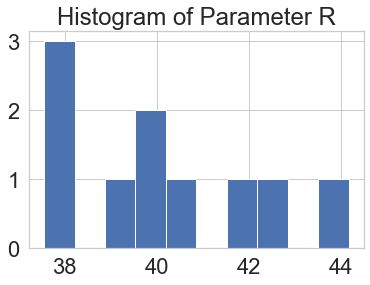

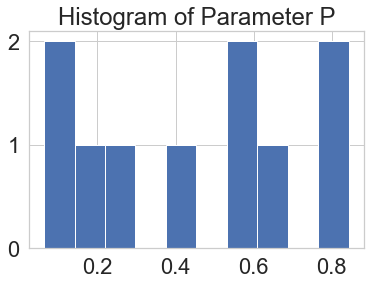

In [135]:
plt.figure()
plt.hist(val_r)
plt.title('Histogram of Parameter R')
plt.figure()
plt.hist(val_p)
plt.title('Histogram of Parameter P')

print('R average: ', val_r_average)
print('P average: ', val_p_average)

In [136]:
model1([val_r_average, val_p_average], [T], [C_0])

array([1244796.19662221])

# References

- **Viboud et al 2015** Viboud, C., Simonsen, L. and Chowell, G., 2016. A generalized-growth model to characterize the early ascending phase of infectious disease outbreaks. Epidemics, 15, pp.27-37.